BTC/USD Trading Bot for MetaTrader 5
Initializing...
Successfully connected to MT5

Starting BTC/USD Trading Bot in DEMO mode
Set live_trading=True in run() method to enable real trading

Running analysis at 2025-07-06 15:02:03.081545
Market Signal: HOLD


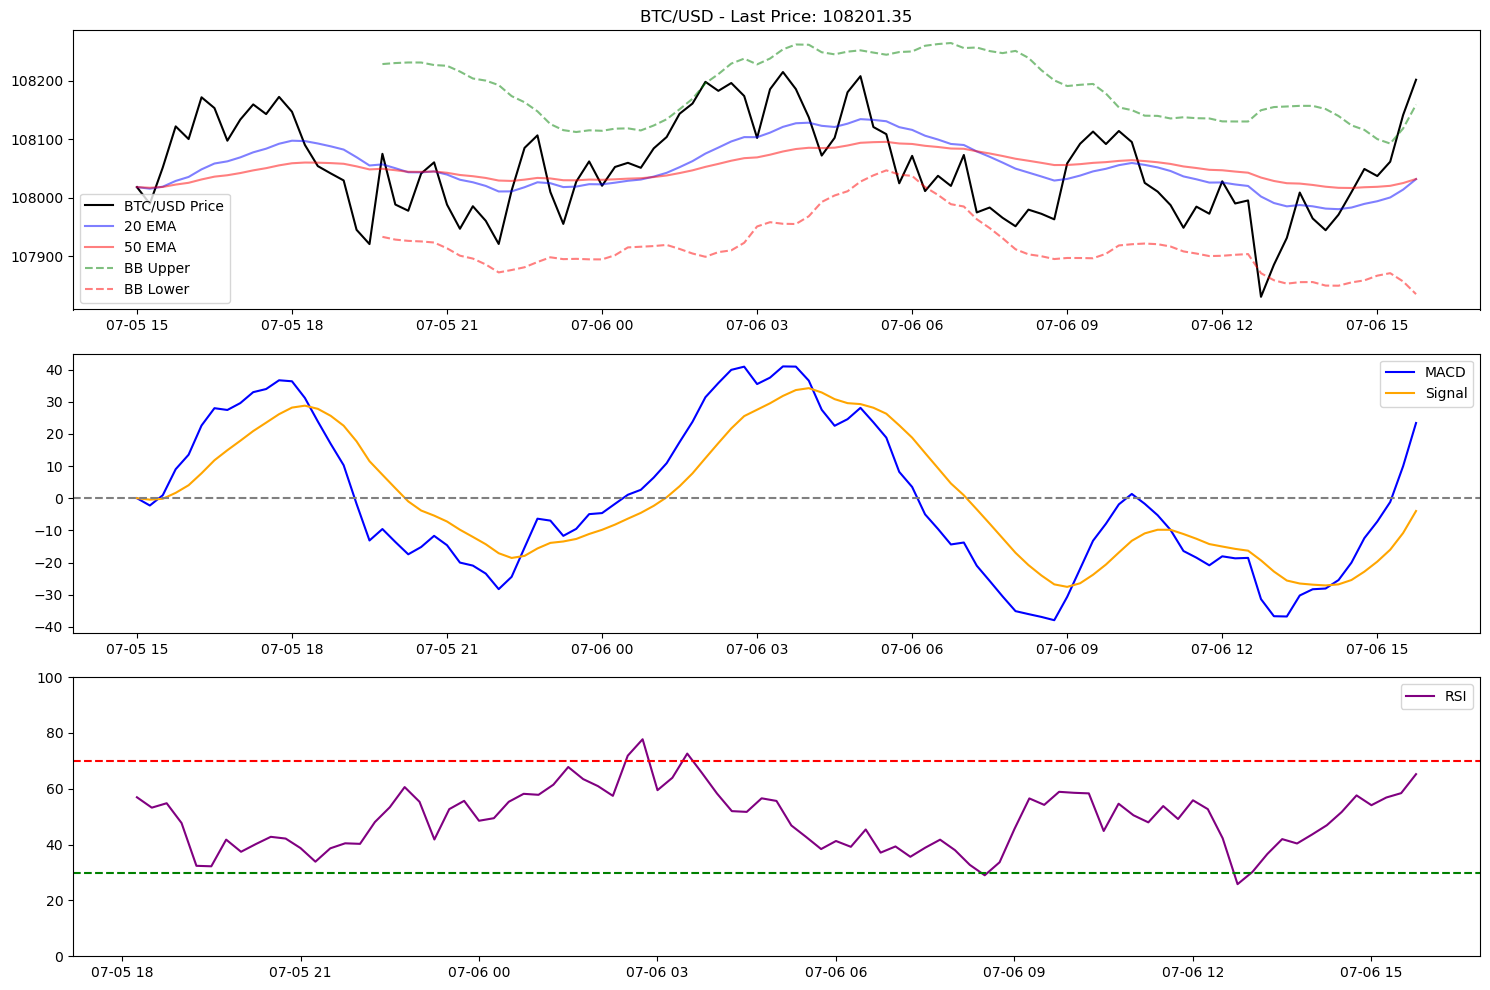

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

# Custom technical analysis functions to replace 'ta' library
def calculate_ema(series, window):
    return series.ewm(span=window, adjust=False).mean()

def calculate_macd(series, slow=26, fast=12, signal=9):
    ema_fast = calculate_ema(series, fast)
    ema_slow = calculate_ema(series, slow)
    macd_line = ema_fast - ema_slow
    signal_line = calculate_ema(macd_line, signal)
    return macd_line, signal_line

def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

class BTCUSD_MT5_Trader:
    def __init__(self, lot_size=0.1, max_spread=5, take_profit_pips=200, stop_loss_pips=100):
        """
        Initialize the trading bot with parameters:
        :param lot_size: Trade volume in BTC
        :param max_spread: Maximum allowed spread in pips
        :param take_profit_pips: Take profit level in pips
        :param stop_loss_pips: Stop loss level in pips
        """
        self.lot_size = lot_size
        self.max_spread = max_spread
        self.take_profit = take_profit_pips
        self.stop_loss = stop_loss_pips
        
        # Connect to MT5
        if not mt5.initialize():
            print("Failed to initialize MT5 connection")
            mt5.shutdown()
            raise ConnectionError("Could not connect to MT5")
        
        print("Successfully connected to MT5")
        
    def get_btcusd_data(self, timeframe=mt5.TIMEFRAME_M15, num_bars=100):
        """
        Retrieve BTC/USD historical data
        :param timeframe: MT5 timeframe constant
        :param num_bars: Number of bars to retrieve
        :return: DataFrame with price data and indicators
        """
        rates = mt5.copy_rates_from_pos("BTCUSD", timeframe, 0, num_bars)
        df = pd.DataFrame(rates)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('time', inplace=True)
        
        # Calculate indicators using custom functions
        df['ema_20'] = calculate_ema(df['close'], 20)
        df['ema_50'] = calculate_ema(df['close'], 50)
        
        df['macd'], df['macd_signal'] = calculate_macd(df['close'])
        
        df['rsi'] = calculate_rsi(df['close'])
        
        df['bb_upper'], df['bb_lower'] = calculate_bollinger_bands(df['close'])
        
        return df
    
    def analyze_market(self, df):
        """
        Analyze the market and generate trading signals
        :param df: DataFrame with price data and indicators
        :return: Signal (1=buy, -1=sell, 0=hold)
        """
        last_row = df.iloc[-1]
        prev_row = df.iloc[-2]
        
        # Trend condition (EMA crossover)
        ema_trend = 1 if (last_row['ema_20'] > last_row['ema_50'] and 
                         prev_row['ema_20'] <= prev_row['ema_50']) else -1 if (
                         last_row['ema_20'] < last_row['ema_50'] and 
                         prev_row['ema_20'] >= prev_row['ema_50']) else 0
        
        # MACD condition
        macd_trend = 1 if (last_row['macd'] > last_row['macd_signal'] and 
                          prev_row['macd'] <= prev_row['macd_signal']) else -1 if (
                          last_row['macd'] < last_row['macd_signal'] and 
                          prev_row['macd'] >= prev_row['macd_signal']) else 0
        
        # RSI condition
        rsi_condition = 1 if last_row['rsi'] < 30 else -1 if last_row['rsi'] > 70 else 0
        
        # Bollinger Bands condition
        bb_condition = 1 if last_row['close'] < last_row['bb_lower'] else -1 if last_row['close'] > last_row['bb_upper'] else 0
        
        # Combine signals (simple majority vote)
        signals = [ema_trend, macd_trend, rsi_condition, bb_condition]
        buy_signals = sum(1 for s in signals if s == 1)
        sell_signals = sum(1 for s in signals if s == -1)
        
        if buy_signals >= 2 and sell_signals < 2:
            return 1  # Buy signal
        elif sell_signals >= 2 and buy_signals < 2:
            return -1  # Sell signal
        else:
            return 0  # No clear signal
    
    def check_risk_conditions(self):
        """
        Check if market conditions are acceptable for trading
        :return: Boolean (True if conditions are good)
        """
        symbol_info = mt5.symbol_info("BTCUSD")
        if symbol_info is None:
            print("BTCUSD not found")
            return False
        
        # Check spread
        spread = symbol_info.ask - symbol_info.bid
        if spread > self.max_spread * symbol_info.point:
            print(f"Spread too wide: {spread/symbol_info.point:.1f} pips")
            return False
            
        # Check market is open
        if not symbol_info.trade_mode == mt5.SYMBOL_TRADE_MODE_FULL:
            print("Market not open for trading")
            return False
            
        return True
    
    def place_order(self, signal):
        """
        Place an order based on the signal
        :param signal: 1 for buy, -1 for sell
        """
        if not self.check_risk_conditions():
            print("Risk conditions not met - not trading")
            return
        
        symbol = "BTCUSD"
        symbol_info = mt5.symbol_info(symbol)
        point = symbol_info.point
        price = mt5.symbol_info_tick(symbol).ask if signal == 1 else mt5.symbol_info_tick(symbol).bid
        
        # Calculate take profit and stop loss
        if signal == 1:  # Buy
            take_profit = price + self.take_profit * point
            stop_loss = price - self.stop_loss * point
            order_type = mt5.ORDER_BUY
        else:  # Sell
            take_profit = price - self.take_profit * point
            stop_loss = price + self.stop_loss * point
            order_type = mt5.ORDER_SELL
        
        # Prepare order request
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": self.lot_size,
            "type": order_type,
            "price": price,
            "sl": stop_loss,
            "tp": take_profit,
            "deviation": 10,
            "magic": 123456,
            "comment": "Python script open",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        
        # Send order
        result = mt5.order_send(request)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print(f"Order failed, retcode={result.retcode}")
        else:
            print(f"Order succeeded, ticket={result.order}")
    
    def close_all_positions(self):
        """Close all open positions"""
        positions = mt5.positions_get()
        if positions is None:
            print("No positions found")
            return
        
        for position in positions:
            symbol = position.symbol
            position_id = position.ticket
            volume = position.volume
            order_type = mt5.ORDER_BUY if position.type == mt5.ORDER_SELL else mt5.ORDER_SELL
            
            price = mt5.symbol_info_tick(symbol).bid if order_type == mt5.ORDER_SELL else mt5.symbol_info_tick(symbol).ask
            
            close_request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": order_type,
                "position": position_id,
                "price": price,
                "deviation": 10,
                "magic": 123456,
                "comment": "Python script close",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }
            
            result = mt5.order_send(close_request)
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print(f"Failed to close position {position_id}, retcode={result.retcode}")
            else:
                print(f"Position {position_id} closed")
    
    def run(self, live_trading=False):
        """
        Run the trading bot
        :param live_trading: If True, will actually place orders
        """
        try:
            while True:
                print("\n" + "="*50)
                print(f"Running analysis at {datetime.now()}")
                
                # Get market data
                df = self.get_btcusd_data()
                
                # Analyze and get signal
                signal = self.analyze_market(df)
                print(f"Market Signal: {'BUY' if signal == 1 else 'SELL' if signal == -1 else 'HOLD'}")
                
                # Plot for visualization
                self.plot_data(df, signal)
                
                # Place order if in live mode
                if live_trading and signal != 0:
                    self.place_order(signal)
                
                # Wait before next analysis
                time.sleep(900)  # 15 minutes (match our timeframe)
                
        except KeyboardInterrupt:
            print("\nShutting down...")
            if live_trading:
                self.close_all_positions()
            mt5.shutdown()
    
    def plot_data(self, df, signal):
        """Plot the market data with indicators"""
        plt.figure(figsize=(15, 10))
        
        # Plot price and EMAs
        plt.subplot(3, 1, 1)
        plt.plot(df.index, df['close'], label='BTC/USD Price', color='black')
        plt.plot(df.index, df['ema_20'], label='20 EMA', color='blue', alpha=0.5)
        plt.plot(df.index, df['ema_50'], label='50 EMA', color='red', alpha=0.5)
        plt.plot(df.index, df['bb_upper'], label='BB Upper', color='green', linestyle='dashed', alpha=0.5)
        plt.plot(df.index, df['bb_lower'], label='BB Lower', color='red', linestyle='dashed', alpha=0.5)
        
        # Mark signal
        if signal != 0:
            plt.scatter(df.index[-1], df['close'].iloc[-1], 
                        color='green' if signal == 1 else 'red', 
                        s=200, marker='o', alpha=0.5)
        
        plt.title(f"BTC/USD - Last Price: {df['close'].iloc[-1]:.2f}")
        plt.legend()
        
        # Plot MACD
        plt.subplot(3, 1, 2)
        plt.plot(df.index, df['macd'], label='MACD', color='blue')
        plt.plot(df.index, df['macd_signal'], label='Signal', color='orange')
        plt.axhline(0, color='gray', linestyle='--')
        plt.legend()
        
        # Plot RSI
        plt.subplot(3, 1, 3)
        plt.plot(df.index, df['rsi'], label='RSI', color='purple')
        plt.axhline(30, color='green', linestyle='--')
        plt.axhline(70, color='red', linestyle='--')
        plt.ylim(0, 100)
        plt.legend()
        
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Installation check and instructions
    try:
        import MetaTrader5
    except ImportError:
        print("\nERROR: MetaTrader5 package not installed.")
        print("Please install it using: pip install MetaTrader5")
        print("Note: You need to have MetaTrader 5 installed on your computer")
        exit()
    
    print("BTC/USD Trading Bot for MetaTrader 5")
    print("Initializing...")
    
    # Initialize trader with parameters
    trader = BTCUSD_MT5_Trader(
        lot_size=0.01,          # Trade size in BTC
        max_spread=5,         # Max allowed spread in pips
        take_profit_pips=200, # 200 pips take profit
        stop_loss_pips=100    # 100 pips stop loss
    )
    
    # Run in demo mode (set live_trading=True for real trading)
    print("\nStarting BTC/USD Trading Bot in DEMO mode")
    print("Set live_trading=True in run() method to enable real trading")
    trader.run(live_trading=False)